In [1]:
import pandas as pd
import glob

# Find all your result CSV files in the current directory
all_files = glob.glob('results_*.csv')

# --- DIAGNOSTIC STEP ---
# This will show you if any files were found.
# If it prints an empty list [], your notebook is in the wrong place.
print("Found the following files to analyze:")
print(all_files)
# --------------------

# Create a list to hold each DataFrame
li = []

# Loop through the files, read them, and add platform/test info
for filename in all_files:
    df = pd.read_csv(filename)
    # Extract info from the filename
    parts = filename.replace('.csv', '').split('_')
    df['platform'] = parts[1].upper()
    df['test_type'] = parts[2].upper()
    df['payload_size'] = parts[3]
    li.append(df)

# Check if the list of dataframes is empty before concatenating
if not li:
    print("\nERROR: No dataframes were created because no CSV files were found.")
    print("Please ensure your 'analysis.ipynb' notebook is in the same folder as your 'results_*.csv' files.")
else:
    # Combine all DataFrames into one
    master_df = pd.concat(li, axis=0, ignore_index=True)
    
    # Crucial step: Convert payload_size to a numeric type for correct plotting
    master_df['payload_size'] = pd.to_numeric(master_df['payload_size'])

    print("\nSuccessfully loaded and combined all data!")
    # Use display() in Jupyter to get a nicely formatted table
    display(master_df.head())

Found the following files to analyze:
['results_aws_cpubound_1000.csv', 'results_aws_cpubound_300.csv', 'results_aws_iobound_1024.csv', 'results_aws_iobound_256.csv', 'results_azure_cpubound_1000.csv', 'results_azure_cpubound_300.csv', 'results_azure_iobound_1024.csv', 'results_azure_iobound_256.csv']

Successfully loaded and combined all data!


,request_id,status_code,end_to_end_latency_ms,server_duration_ms,network_latency_ms,platform,test_type,payload_size
0,1,200,716.14,497.91,218.23,AWS,CPUBOUND,1000
1,2,200,750.57,499.13,251.44,AWS,CPUBOUND,1000
2,3,200,704.62,456.28,248.34,AWS,CPUBOUND,1000
3,4,200,712.59,498.50,214.09,AWS,CPUBOUND,1000
4,5,200,739.50,499.43,240.07,AWS,CPUBOUND,1000


<Figure size 1600x800 with 0 Axes>

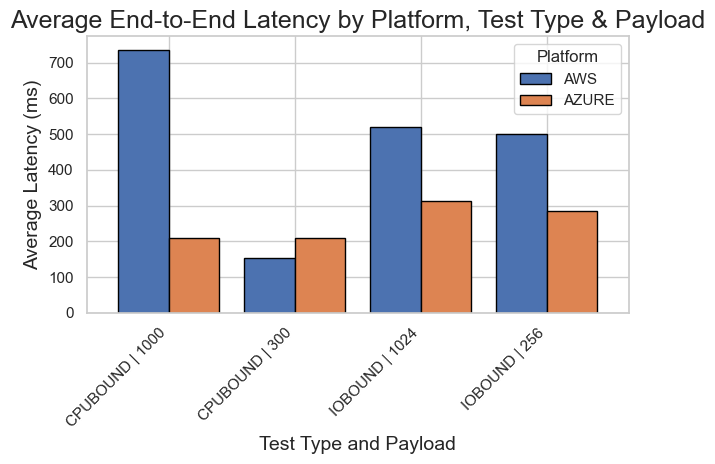

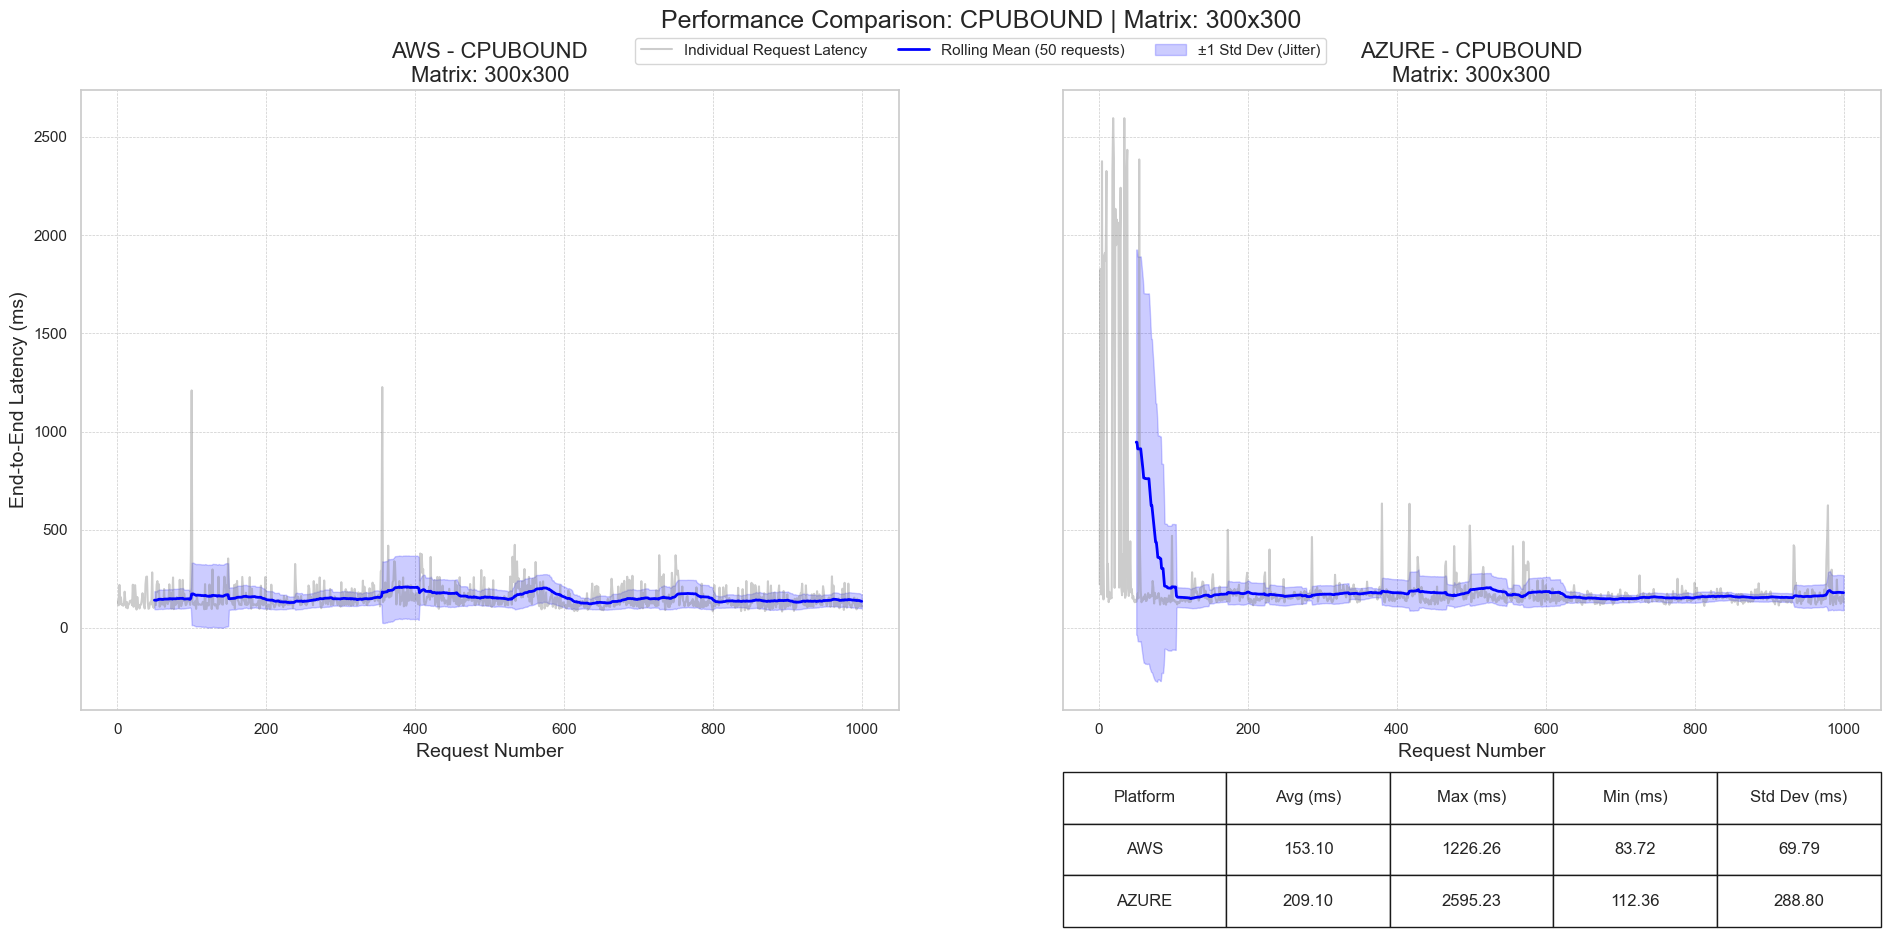

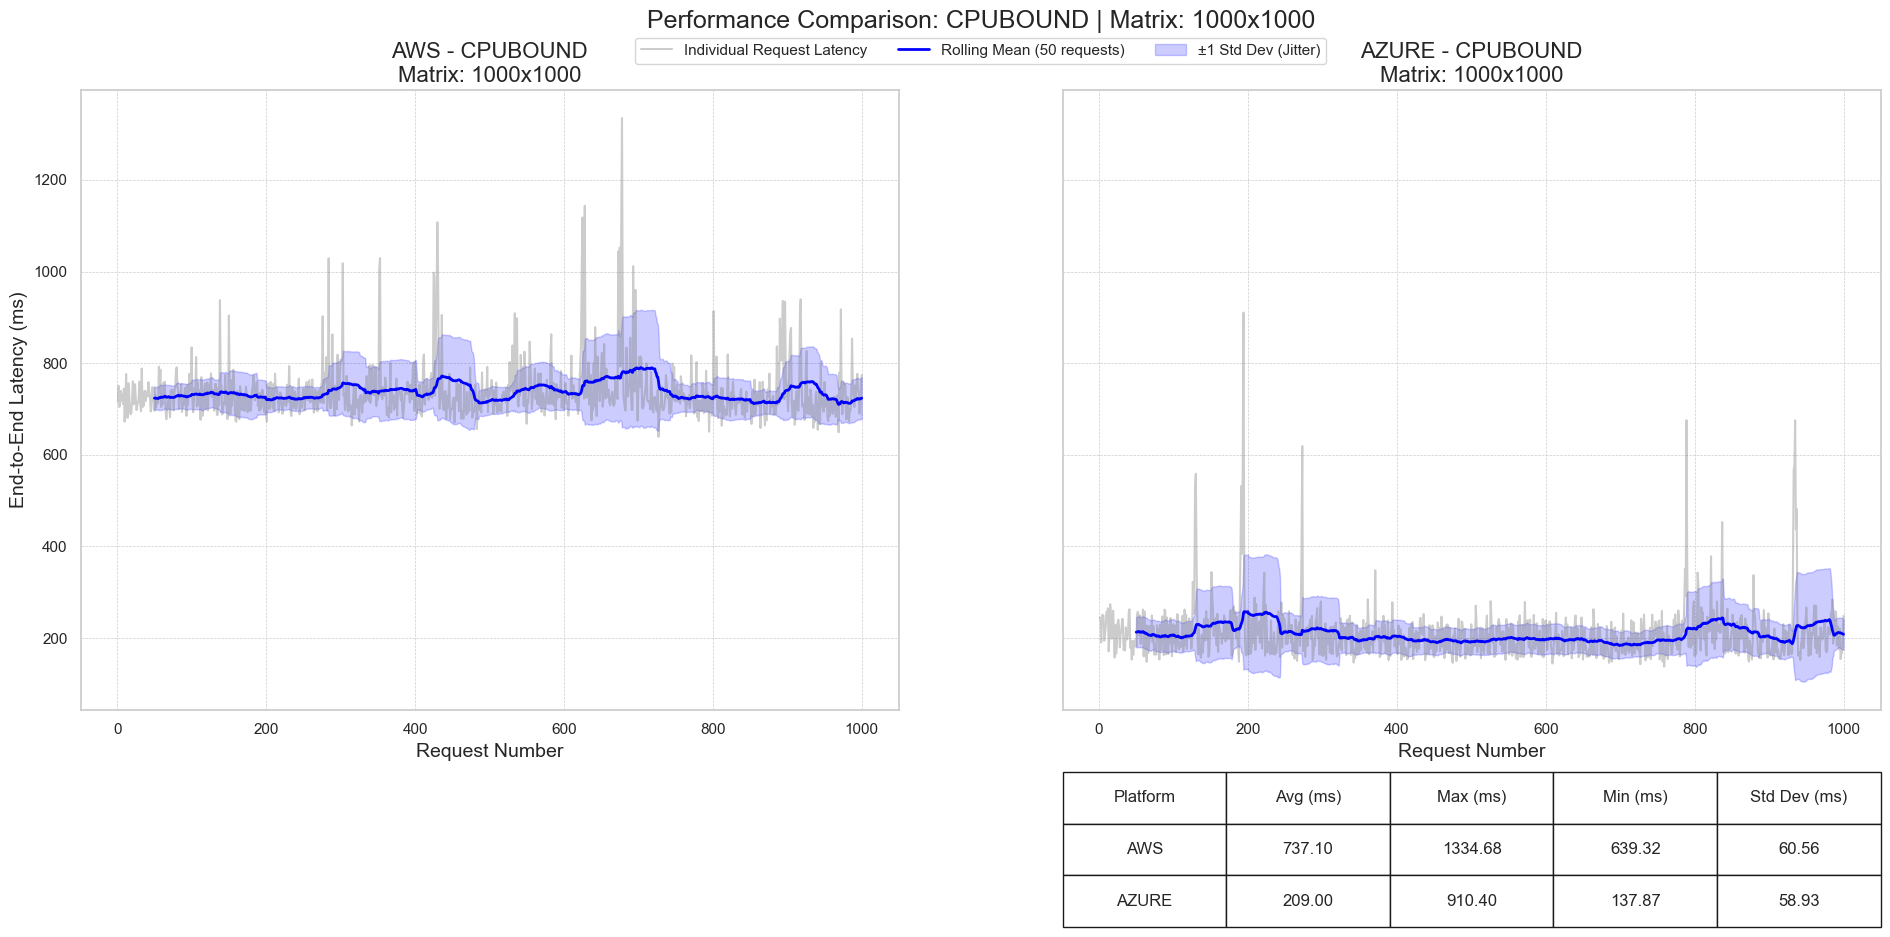

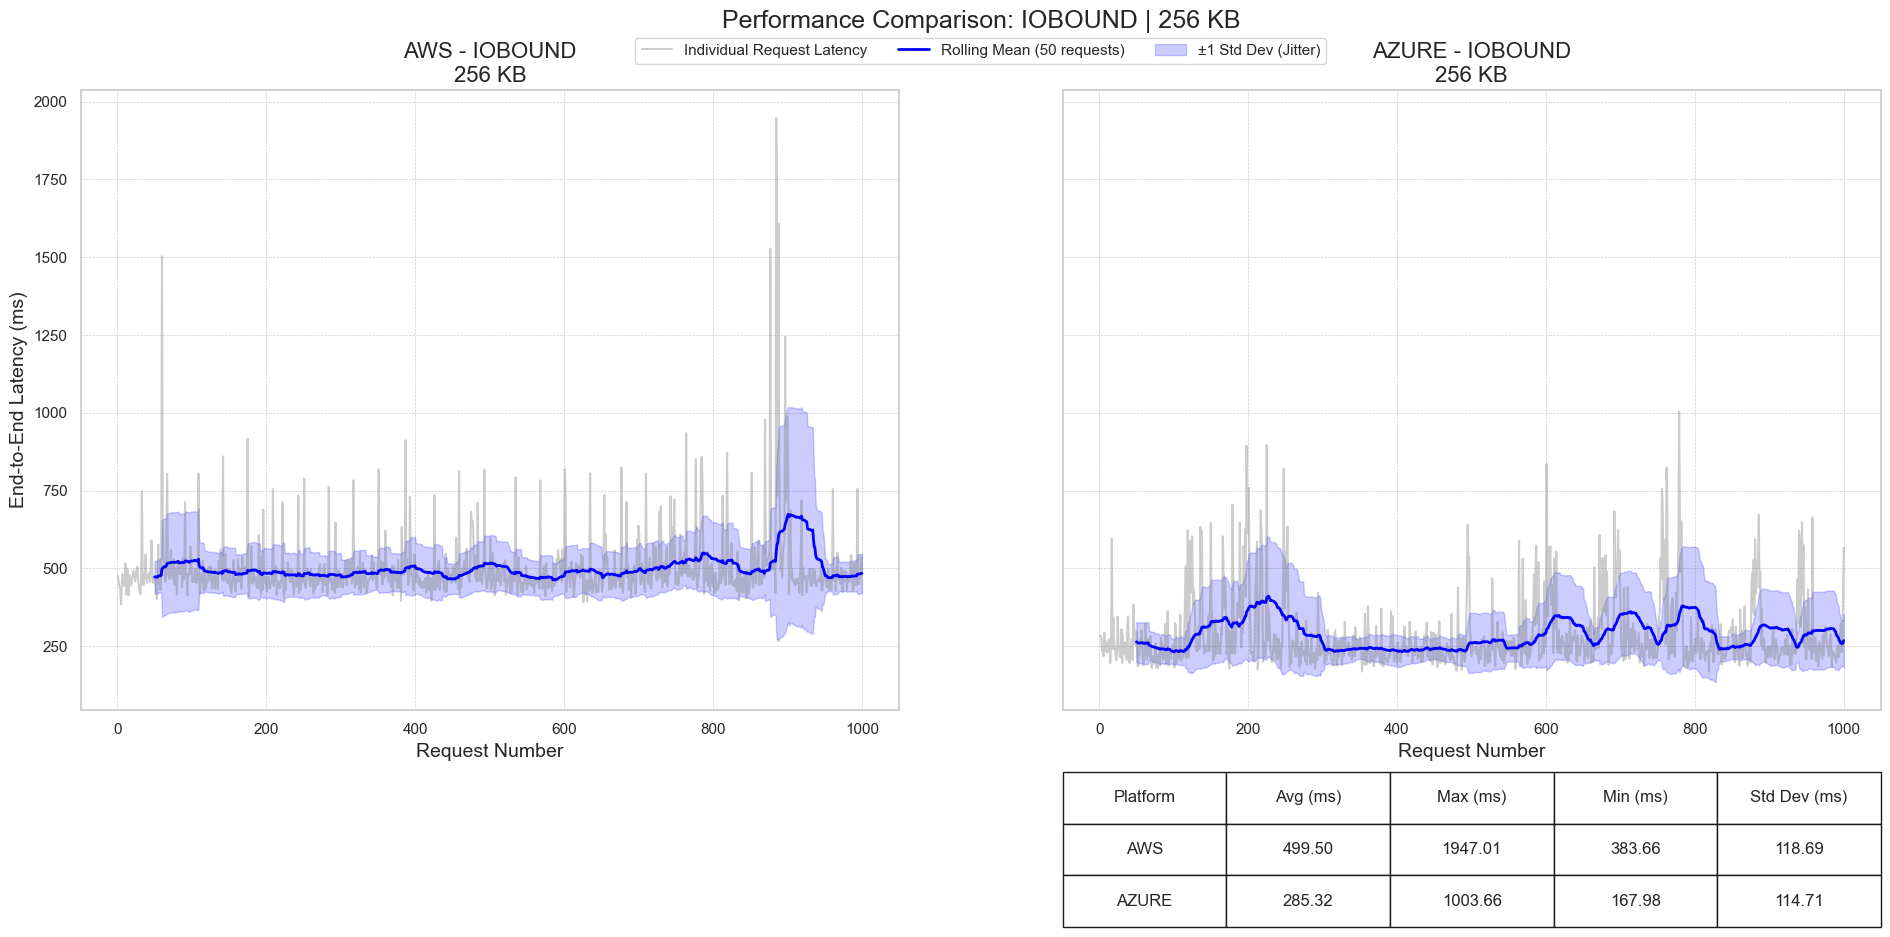

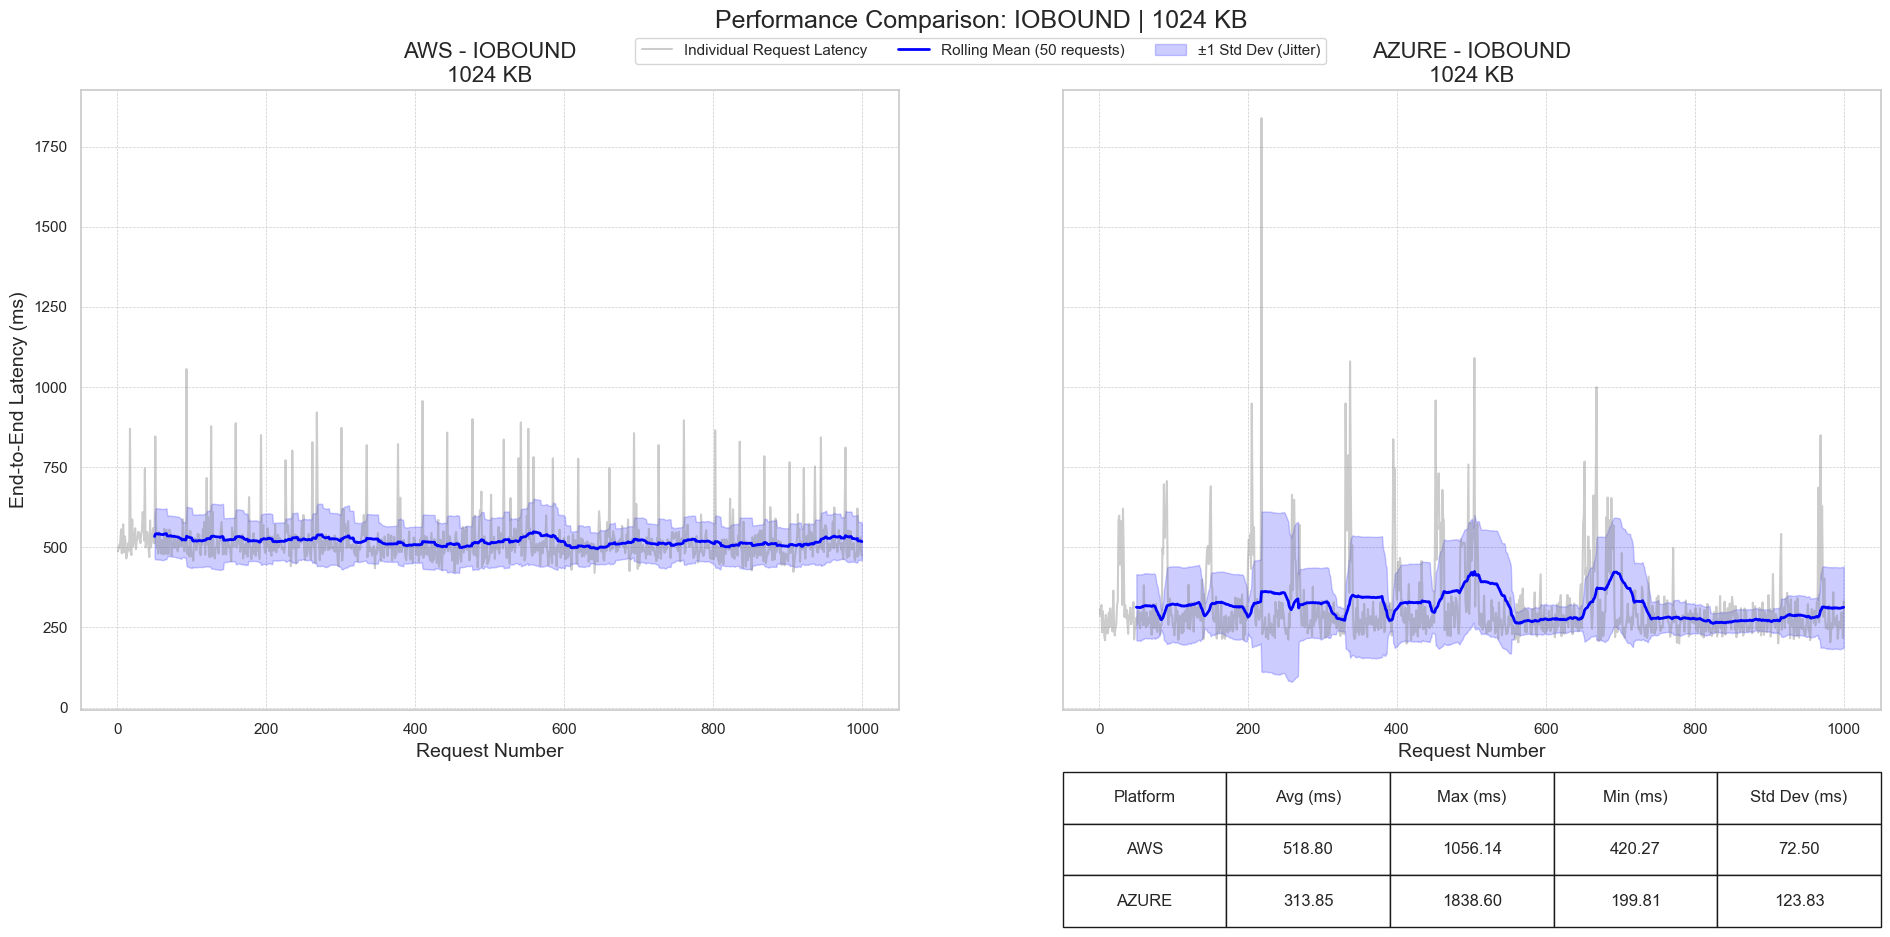

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent types and casing
master_df['payload_size'] = master_df['payload_size'].astype(int)
master_df['platform'] = master_df['platform'].str.upper()
master_df['test_type'] = master_df['test_type'].str.upper()

test_types = sorted(master_df['test_type'].unique())
payloads = sorted(master_df['payload_size'].unique())
platforms = ['AWS', 'AZURE']

# Function to format payload label differently for CPU vs I/O tests
def format_payload(test_type, payload):
    if test_type == 'CPUBOUND':
        return f'Matrix: {payload}x{payload}'
    else:
        return f'{payload} KB'

#Bar Chart
summary_rows = []
for test_type in test_types:
    for payload in payloads:
        for platform in platforms:
            subset = master_df[
                (master_df['platform'] == platform) &
                (master_df['test_type'] == test_type) &
                (master_df['payload_size'] == payload)
            ]
            if subset.empty:
                continue
            summary_rows.append({
                'test_type': test_type,
                'payload_size': payload,
                'platform': platform,
                'avg_latency': subset['end_to_end_latency_ms'].mean()
            })

summary_df = pd.DataFrame(summary_rows)

if not summary_df.empty:
    summary_df['test_payload'] = summary_df['test_type'] + ' | ' + summary_df['payload_size'].astype(str)

    plt.figure(figsize=(16, 8))  # <-- Larger bar chart
    plot_df = summary_df.pivot(index='test_payload', columns='platform', values='avg_latency')
    plot_df = plot_df.sort_index()
    colors = sns.color_palette('deep', n_colors=len(platforms))

    plot_df.plot(kind='bar', width=0.8, edgecolor='black', color=colors)
    plt.title('Average End-to-End Latency by Platform, Test Type & Payload', fontsize=18)
    plt.ylabel('Average Latency (ms)', fontsize=14)
    plt.xlabel('Test Type and Payload', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Platform')
    plt.tight_layout()
    plt.show()

# ---- ROLLING/JITTER PLOTS with TABLE ----
for test_type in test_types:
    for payload in payloads:
        fig, axes = plt.subplots(
            nrows=1, ncols=2,
            figsize=(20, 10),  # <-- Larger figure for clarity
            sharey=True,
            gridspec_kw={'height_ratios': [3]}
        )
        data_found = False
        stats_summary = []

        for i, platform in enumerate(platforms):
            subset = master_df[
                (master_df['platform'] == platform) &
                (master_df['test_type'] == test_type) &
                (master_df['payload_size'] == payload)
            ]
            if subset.empty:
                axes[i].text(0.5, 0.5, f'No data for {platform}',
                             ha='center', va='center', fontsize=14)
                axes[i].set_title(f'{platform} - {test_type}\n{format_payload(test_type, payload)}', fontsize=16)
                axes[i].axis('off')
                continue

            data_found = True
            rolling_mean = subset['end_to_end_latency_ms'].rolling(window=50).mean()
            rolling_std = subset['end_to_end_latency_ms'].rolling(window=50).std()

            axes[i].plot(subset['request_id'], subset['end_to_end_latency_ms'],
                         label='Individual Request Latency', color='grey', alpha=0.4)
            axes[i].plot(subset['request_id'], rolling_mean,
                         label='Rolling Mean (50 requests)', color='blue', linewidth=2)
            axes[i].fill_between(subset['request_id'],
                                 rolling_mean - rolling_std,
                                 rolling_mean + rolling_std,
                                 color='blue', alpha=0.2,
                                 label='±1 Std Dev (Jitter)')

            axes[i].set_title(f'{platform} - {test_type}\n{format_payload(test_type, payload)}', fontsize=16)
            axes[i].set_xlabel('Request Number', fontsize=14)
            axes[i].grid(True, linestyle='--', linewidth=0.5)
            if i == 0:
                axes[i].set_ylabel('End-to-End Latency (ms)', fontsize=14)

            # Collect stats for table
            stats_summary.append([
                platform,
                f"{subset['end_to_end_latency_ms'].mean():.2f}",
                f"{subset['end_to_end_latency_ms'].max():.2f}",
                f"{subset['end_to_end_latency_ms'].min():.2f}",
                f"{subset['end_to_end_latency_ms'].std():.2f}"
            ])

        if data_found:
            fig.suptitle(f'Performance Comparison: {test_type} | {format_payload(test_type, payload)}',
                         fontsize=18)

            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)

            # Embed table with larger size
            col_labels = ["Platform", "Avg (ms)", "Max (ms)", "Min (ms)", "Std Dev (ms)"]
            table = plt.table(cellText=stats_summary,
                              colLabels=col_labels,
                              cellLoc='center',
                              loc='bottom',
                              bbox=[0.0, -0.35, 1, 0.25])

            table.auto_set_font_size(False)
            table.set_fontsize(12)

            plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.28)
            plt.show()
        else:
            plt.close()


In [51]:
import csv
import os

def create_or_update_csv(filename, headers, data):
    """
    Creates or updates a CSV file with the provided headers and data.
    Overwrites the file if it already exists.
    """
    try:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(headers)
            writer.writerows(data)
        print(f"SUCCESS: Created/Updated CSV file '{filename}'.")
    except IOError as e:
        print(f"ERROR: Could not write to file '{filename}'. Reason: {e}")


if __name__ == "__main__":
    print("Generating/updating CSV configuration files for TCO analysis script...")

    # --- 1. Define data for pricing_models.csv ---
    pricing_headers = ['platform', 'metric', 'value']
    pricing_data = [
        ['AWS', 'invocation_price_per_million', 0.17],
        ['AWS', 'compute_price_per_gb_second', 0.0000133],
        ['AWS', 'gateway_price_per_million', 0.89],
        ['AWS', 'logging_ingestion_price_per_gb', 0.46],
        ['AWS', 'transfer_out_price_per_gb', 0.07],
        ['AWS', 'free_tier_invocations', 1000000],
        ['AWS', 'free_tier_compute_gb_seconds', 400000],
        ['Azure', 'invocation_price_per_million', 0.162],
        ['Azure', 'compute_price_per_gb_second', 0.000013],
        ['Azure', 'gateway_price_per_million', 3.279],
        ['Azure', 'logging_ingestion_price_per_gb', 2.246],
        ['Azure', 'transfer_out_price_per_gb', 0.07],
        ['Azure', 'free_tier_invocations', 1000000],
        ['Azure', 'free_tier_compute_gb_seconds', 400000]
    ]

    # --- 2. Define data for manual_metrics_input.csv ---
    # UPDATED: Azure memory values are now set to the allocated 2048MB.
    manual_metrics_headers = [
        'platform', 'test_type', 'payload', 
        'avg_memory_used_mb_manual', 'avg_log_size_kb_manual', 'avg_transfer_out_kb_manual'
    ]
    manual_metrics_data = [
        # AWS - Memory is blank (auto-calculated from logs), log sizes are from your data.
        ['AWS', 'CPU-Bound', 300, '', 0.17, 2],
        ['AWS', 'CPU-Bound', 1000, '', 0.16, 2],
        ['AWS', 'IO-Bound', 256, '', 0.43, 256],
        ['AWS', 'IO-Bound', 1024, '', 0.43, 1024],
        # Azure - Memory set to 2048MB, log sizes are from your data.
        ['Azure', 'CPU-Bound', 300, 2048, 1.18, 2],
        ['Azure', 'CPU-Bound', 1000, 2048, 1.18, 2],
        ['Azure', 'IO-Bound', 256, 2048, 1.17, 256],
        ['Azure', 'IO-Bound', 1024, 2048, 1.18, 1024]
    ]

    # --- 3. Create or Update Files ---
    create_or_update_csv('pricing_models.csv', pricing_headers, pricing_data)
    create_or_update_csv('manual_metrics_input.csv', manual_metrics_headers, manual_metrics_data)

    print("\nAll CSV files are now up-to-date and ready for the TCO analysis script.")

Generating/updating CSV configuration files for TCO analysis script...
SUCCESS: Created/Updated CSV file 'pricing_models.csv'.
SUCCESS: Created/Updated CSV file 'manual_metrics_input.csv'.

All CSV files are now up-to-date and ready for the TCO analysis script.


In [12]:
import pandas as pd

def find_azure_test_timestamps(filename="Azure Monitor/azure-logs.csv"):
    """
    Loads the exported Azure logs CSV, sorts it, and identifies the
    start and end timestamps for each of the four test runs.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        print(f"Successfully loaded {filename} with {len(df)} rows.")

        # --- Data Cleaning and Preparation ---
        # Clean up column names that might have leading/trailing spaces
        df.columns = [col.strip() for col in df.columns]

        # Rename the timestamp column if it has '[UTC]' in it
        if 'timestamp [UTC]' in df.columns:
            df.rename(columns={'timestamp [UTC]': 'timestamp'}, inplace=True)
        
        # Convert the timestamp column to a proper datetime object for sorting
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Ensure the entire dataset is sorted chronologically
        df.sort_values(by='timestamp', inplace=True)
        df.reset_index(drop=True, inplace=True)

        # --- Separate Data by Function Type ---
        cpu_df = df[df['name'] == 'CPU-Bound']
        io_df = df[df['name'] == 'IO-Bound']

        if len(cpu_df) < 2020 or len(io_df) < 2020:
            print("\nWarning: The CSV does not contain the expected 2020 rows for each function type.")
            print(f"Found {len(cpu_df)} for CPU-Bound and {len(io_df)} for IO-Bound.")
        
        # --- Identify and Extract Timestamps for Each Batch ---
        timestamps = {}

        if not cpu_df.empty:
            cpu_payload1_df = cpu_df.iloc[0:1010]
            cpu_payload2_df = cpu_df.iloc[1010:2020]
            if not cpu_payload1_df.empty:
                timestamps['CPU-Bound (Payload 1: 300)'] = {
                    'start_time_utc': cpu_payload1_df['timestamp'].min(),
                    'end_time_utc': cpu_payload1_df['timestamp'].max()
                }
            if not cpu_payload2_df.empty:
                timestamps['CPU-Bound (Payload 2: 1000)'] = {
                    'start_time_utc': cpu_payload2_df['timestamp'].min(),
                    'end_time_utc': cpu_payload2_df['timestamp'].max()
                }

        if not io_df.empty:
            io_payload1_df = io_df.iloc[0:1010]
            io_payload2_df = io_df.iloc[1010:2020]
            if not io_payload1_df.empty:
                timestamps['IO-Bound (Payload 1: 256KB)'] = {
                    'start_time_utc': io_payload1_df['timestamp'].min(),
                    'end_time_utc': io_payload1_df['timestamp'].max()
                }
            if not io_payload2_df.empty:
                timestamps['IO-Bound (Payload 2: 1024KB)'] = {
                    'start_time_utc': io_payload2_df['timestamp'].min(),
                    'end_time_utc': io_payload2_df['timestamp'].max()
                }

        # --- Print the Results ---
        print("\n--- Identified Test Time Windows (in UTC) ---")
        for test_name, times in timestamps.items():
            print(f"\nTest: {test_name}")
            print(f"  Start Time: {times['start_time_utc']}")
            print(f"  End Time:   {times['end_time_utc']}")
        
        print("\nYou can now use these UTC timestamps in the Azure Log Analytics query to find the log sizes.")


    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        print("Please make sure the CSV file is in the same directory as this script or provide the full path.")
    except KeyError as e:
        print(f"Error: A required column is missing from the CSV file: {e}")
        print("Please ensure your CSV contains 'name' and a 'timestamp' column.")

# Run the function
if __name__ == "__main__":
    find_azure_test_timestamps()

Successfully loaded Azure Monitor/azure-logs.csv with 4040 rows.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21724\554209989.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])



--- Identified Test Time Windows (in UTC) ---

Test: CPU-Bound (Payload 1: 300)
  Start Time: 2025-08-02 15:18:55.421000
  End Time:   2025-08-02 15:24:26.936000

Test: CPU-Bound (Payload 2: 1000)
  Start Time: 2025-08-02 15:25:27.275000
  End Time:   2025-08-02 15:30:39.645000

Test: IO-Bound (Payload 1: 256KB)
  Start Time: 2025-08-02 15:31:40.085000
  End Time:   2025-08-02 15:38:09.573000

Test: IO-Bound (Payload 2: 1024KB)
  Start Time: 2025-08-02 15:39:10.069000
  End Time:   2025-08-02 15:46:07.767000

You can now use these UTC timestamps in the Azure Log Analytics query to find the log sizes.


In [22]:
import pandas as pd

def find_aws_test_timestamps(filename="AWS Cloudwatch/aws-logs.csv"):
    """
    Loads the exported AWS logs CSV, sorts it, and identifies the
    start and end timestamps for each of the four test runs.
    """
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        print(f"Successfully loaded {filename} with {len(df)} rows.")

        # --- Data Cleaning and Preparation ---
        df.columns = [col.strip() for col in df.columns]
        df['@timestamp'] = pd.to_datetime(df['@timestamp'])
        df.sort_values(by='@timestamp', inplace=True)
        df.reset_index(drop=True, inplace=True)

        # --- Separate Data by Function Type ---
        cpu_df = df[df['full_function'].str.contains('CpuBound', case=False)]
        io_df = df[df['full_function'].str.contains('IoBound', case=False)]

        if len(cpu_df) < 2020 or len(io_df) < 2020:
            print("\nWarning: The CSV does not contain the expected 2020 rows for each function type.")
            print(f"Found {len(cpu_df)} for CPU-Bound and {len(io_df)} for IO-Bound.")

        # --- Identify and Extract Timestamps for Each Batch ---
        timestamps = {}

        if not cpu_df.empty:
            cpu_payload1_df = cpu_df.iloc[0:1010]
            cpu_payload2_df = cpu_df.iloc[1010:2020]
            if not cpu_payload1_df.empty:
                timestamps['AWS CPU-Bound (Payload 1: 300)'] = {
                    'start_time': cpu_payload1_df['@timestamp'].min(),
                    'end_time': cpu_payload1_df['@timestamp'].max()
                }
            if not cpu_payload2_df.empty:
                timestamps['AWS CPU-Bound (Payload 2: 1000)'] = {
                    'start_time': cpu_payload2_df['@timestamp'].min(),
                    'end_time': cpu_payload2_df['@timestamp'].max()
                }

        if not io_df.empty:
            io_payload1_df = io_df.iloc[0:1010]
            io_payload2_df = io_df.iloc[1010:2020]
            if not io_payload1_df.empty:
                timestamps['AWS IO-Bound (Payload 1: 256KB)'] = {
                    'start_time': io_payload1_df['@timestamp'].min(),
                    'end_time': io_payload1_df['@timestamp'].max()
                }
            if not io_payload2_df.empty:
                timestamps['AWS IO-Bound (Payload 2: 1024KB)'] = {
                    'start_time': io_payload2_df['@timestamp'].min(),
                    'end_time': io_payload2_df['@timestamp'].max()
                }

        # --- Print the Results ---
        print("\n--- Identified AWS Test Time Windows ---")
        for test_name, times in timestamps.items():
            print(f"\nTest: {test_name}")
            print(f"  Start Time: {times['start_time']}")
            print(f"  End Time:   {times['end_time']}")
        
        print("\nYou can now use these timestamps in the AWS CloudWatch Metrics screen to find the log sizes.")

    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
    except KeyError as e:
        print(f"Error: A required column is missing from the CSV file: {e}")

# Run the function
if __name__ == "__main__":
    find_aws_test_timestamps(filename="AWS Cloudwatch/aws-logs.csv")

Successfully loaded AWS Cloudwatch/aws-logs.csv with 4040 rows.

--- Identified AWS Test Time Windows ---

Test: AWS CPU-Bound (Payload 1: 300)
  Start Time: 2025-09-04 12:31:50.792000
  End Time:   2025-09-04 12:36:09.213000

Test: AWS CPU-Bound (Payload 2: 1000)
  Start Time: 2025-09-04 12:37:10.233000
  End Time:   2025-09-04 12:51:20.037000

Test: AWS IO-Bound (Payload 1: 256KB)
  Start Time: 2025-09-04 12:52:23.302000
  End Time:   2025-09-04 13:02:29.845000

Test: AWS IO-Bound (Payload 2: 1024KB)
  Start Time: 2025-09-04 13:03:30.585000
  End Time:   2025-09-04 13:13:55.497000

You can now use these timestamps in the AWS CloudWatch Metrics screen to find the log sizes.


Loading data files...

Processing raw data and merging with manual inputs...
--- Final Combined & Cleaned Metrics ---
  platform  test_type  payload  avg_billed_duration_ms  avg_memory_used_mb  \
0      AWS  CPU-Bound      300                   62.43               95.00   
1      AWS  CPU-Bound     1000                  678.43              119.00   
2      AWS   IO-Bound      256                  367.40              110.95   
3      AWS   IO-Bound     1024                  405.58              114.00   
4    Azure  CPU-Bound      300                   22.15             2048.00   
5    Azure  CPU-Bound     1000                   60.57             2048.00   
6    Azure   IO-Bound      256                  105.71             2048.00   
7    Azure   IO-Bound     1024                  135.41             2048.00   

   avg_log_size_kb  avg_transfer_out_kb  
0             0.17                    2  
1             0.16                    2  
2             0.43                  256  
3          

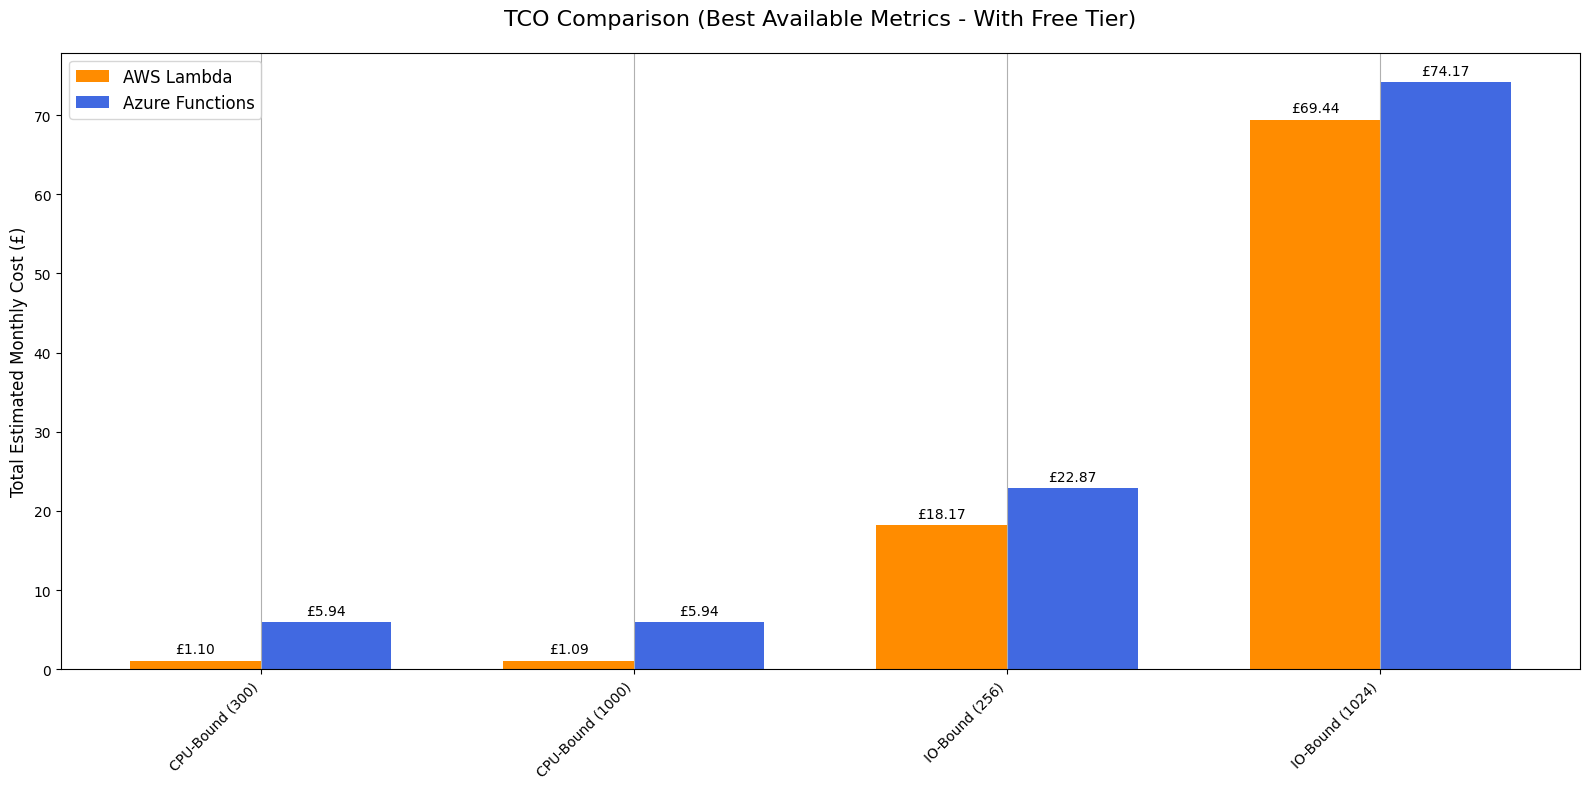

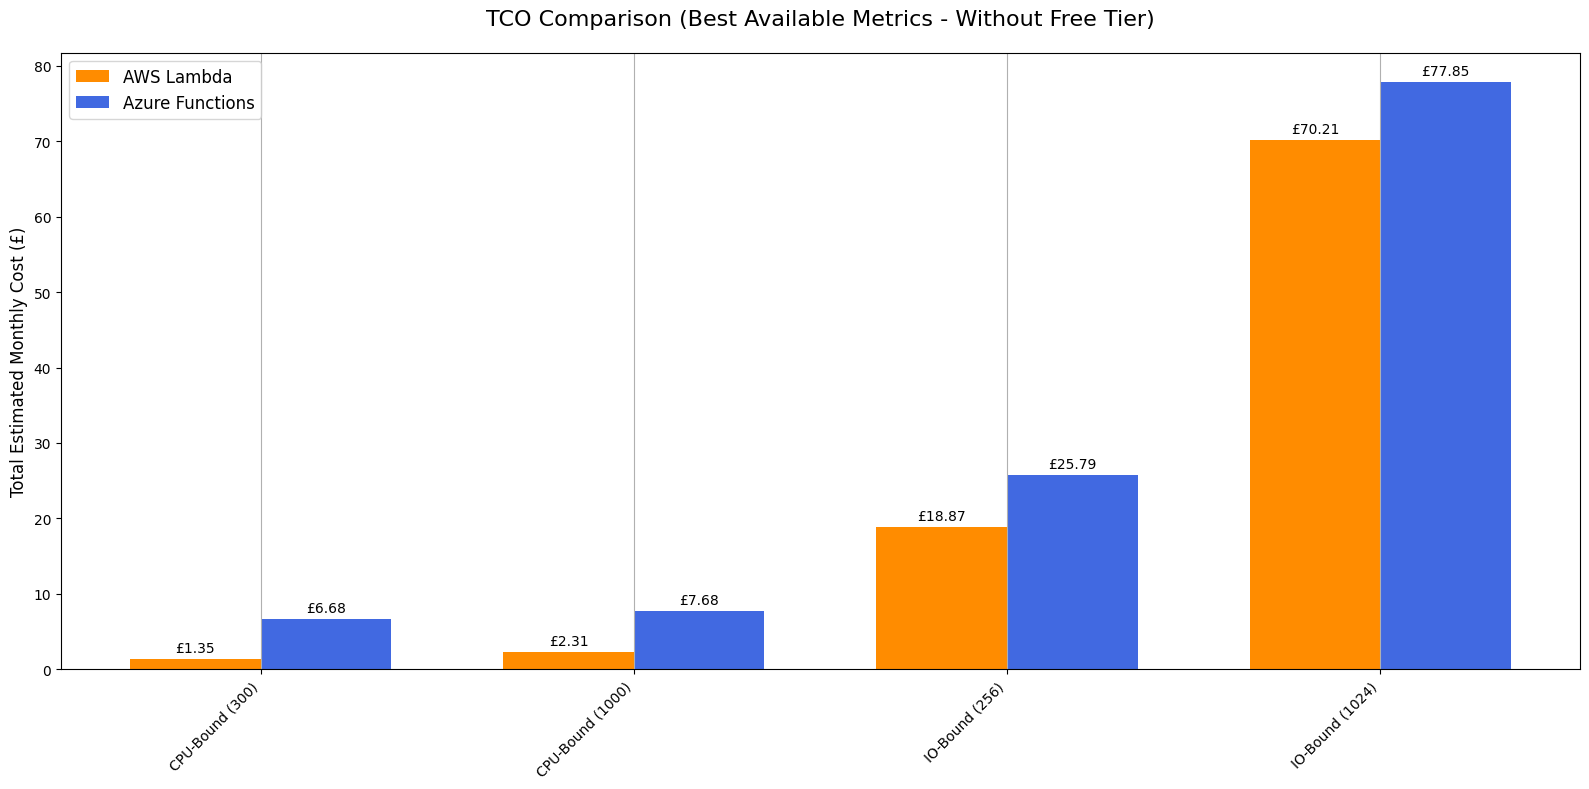

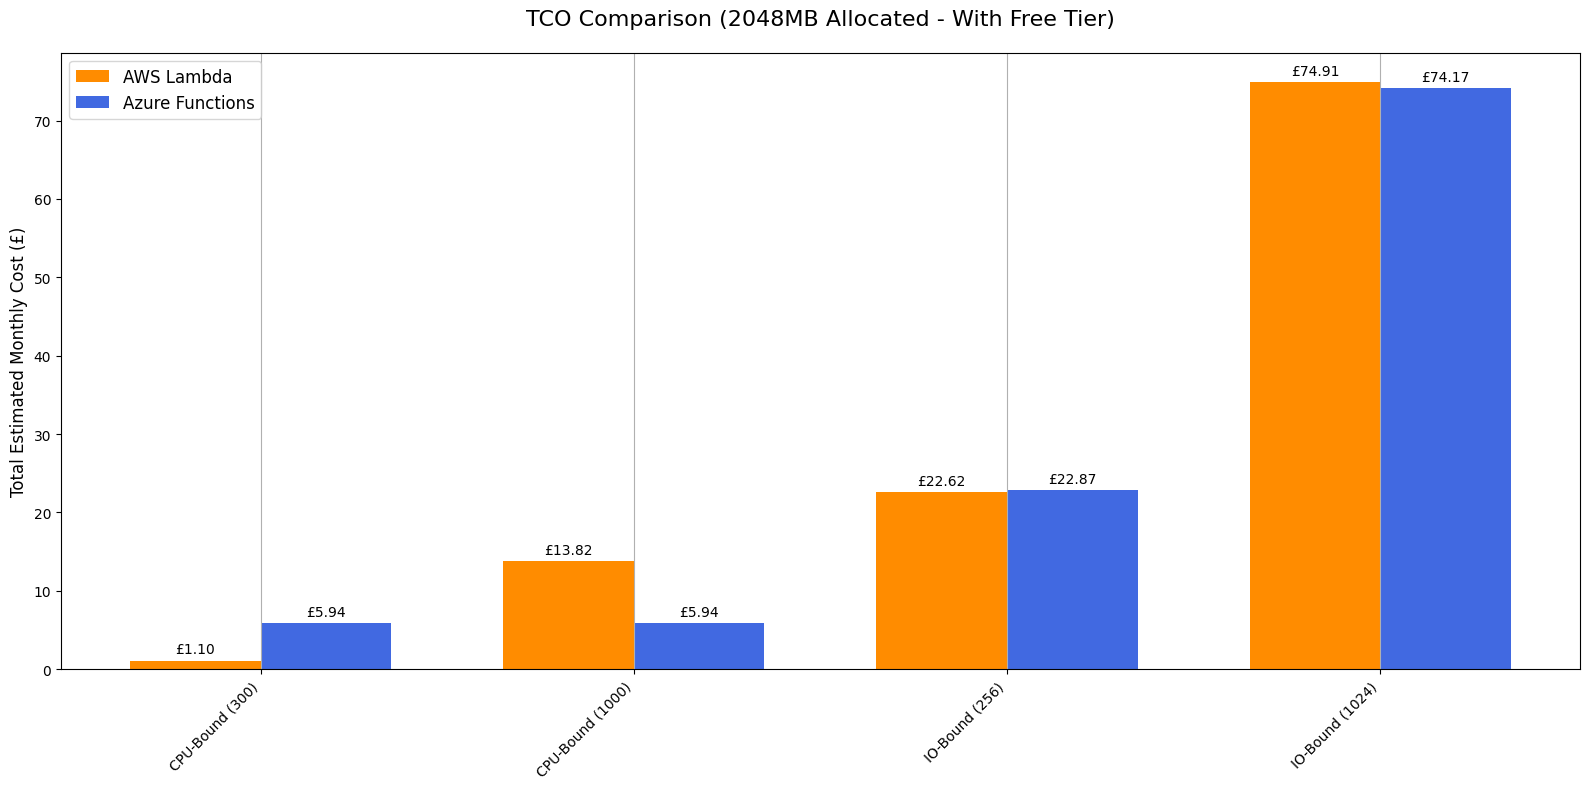

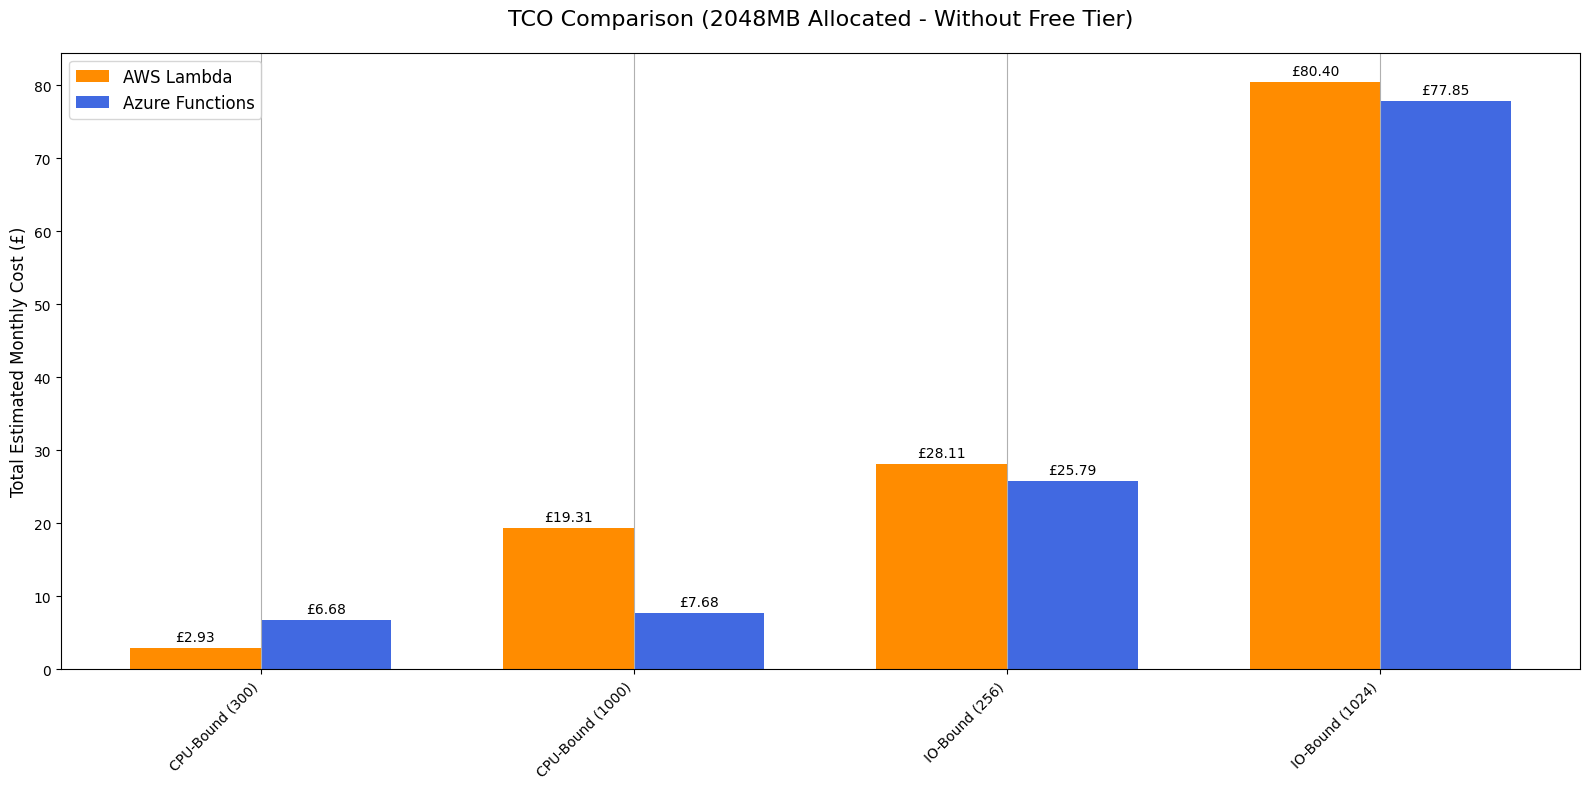


Analysis complete.


In [60]:
#
# Final TCO Analysis Script for AWS Lambda and Azure Functions
#

# --- Section 1: Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Section 2: Function Definitions ---

def process_raw_data(df, platform, aws_memory_mode='actual'):
    """
    Processes the raw log data to calculate metrics that can be derived automatically
    (like duration and AWS memory usage).
    """
    summary_results = []
    
    payloads = {
        'CPU-Bound': [300, 1000],
        'IO-Bound': [256, 1024]
    }
    
    for test_type in ['CPU-Bound', 'IO-Bound']:
        if platform == 'AWS':
            search_term = 'CpuBound' if 'CPU' in test_type else 'IoBound'
            type_df = df[df['full_function'].str.contains(search_term, case=False)].copy()
        else: # Azure
            type_df = df[df['name'] == test_type].copy()
            
        df_payload1 = type_df.iloc[0:1010]
        df_payload2 = type_df.iloc[1010:2020]

        for i, payload_df in enumerate([df_payload1, df_payload2]):
            payload_value = payloads[test_type][i]
            
            measured_df = payload_df.iloc[10:]
            
            if platform == 'AWS':
                avg_duration = measured_df['billed_duration'].mean()
                if aws_memory_mode == 'actual':
                    avg_memory = measured_df['max_memory_used'].mean()
                else: # aws_memory_mode == 'allocated'
                    avg_memory = 2048
            else: # Azure
                avg_duration = measured_df['duration'].mean()
                # Azure's actual memory will be merged in from the manual input file
                avg_memory = np.nan 
                
            summary_results.append({
                'platform': platform, 'test_type': test_type, 'payload': payload_value,
                'avg_billed_duration_ms': avg_duration, 'avg_memory_used_mb': avg_memory
            })
            
    return pd.DataFrame(summary_results)

def calculate_tco(metrics, pricing, apply_free_tier=True):
    """
    Calculates the Total Cost of Ownership for 1 Million Invocations.
    """
    total_invocations = 1_000_000
    memory_gb = metrics["avg_memory_used_mb"] / 1024
    duration_s = metrics["avg_billed_duration_ms"] / 1000

    if apply_free_tier:
        billable_invocations = max(0, total_invocations - pricing.get("free_tier_invocations", 0))
        total_compute_gb_seconds = total_invocations * memory_gb * duration_s
        billable_gb_seconds = max(0, total_compute_gb_seconds - pricing.get("free_tier_compute_gb_seconds", 0))
    else:
        billable_invocations = total_invocations
        billable_gb_seconds = total_invocations * memory_gb * duration_s

    cost_invocations = (billable_invocations / 1_000_000) * pricing["invocation_price_per_million"]
    cost_compute = billable_gb_seconds * pricing["compute_price_per_gb_second"]
    cost_gateway = (total_invocations / 1_000_000) * pricing["gateway_price_per_million"]
    
    total_log_gb = (total_invocations * metrics["avg_log_size_kb"]) / (1024 * 1024)
    cost_logging = total_log_gb * pricing["logging_ingestion_price_per_gb"]
    
    total_transfer_gb = (total_invocations * metrics["avg_transfer_out_kb"]) / (1024 * 1024)
    cost_transfer = total_transfer_gb * pricing["transfer_out_price_per_gb"]
    
    cost_total = cost_invocations + cost_compute + cost_gateway + cost_logging + cost_transfer

    return {
        "Total Cost (£)": cost_total, "Compute Cost": cost_compute, "Invocation Cost": cost_invocations,
        "Gateway Cost": cost_gateway, "Logging Cost": cost_logging, "Transfer Cost": cost_transfer,
    }

def run_full_analysis(summary_df, pricing_aws, pricing_azure, title, csv_filename_prefix):
    """
    Helper function to run TCO calculations, print, and save rounded results to CSV.
    """
    results_with_tier, results_without_tier = [], []
    for index, row in summary_df.iterrows():
        metrics = row.to_dict()
        pricing = pricing_aws if metrics['platform'] == 'AWS' else pricing_azure
        cost_with_tier = calculate_tco(metrics, pricing, apply_free_tier=True)
        cost_without_tier = calculate_tco(metrics, pricing, apply_free_tier=False)
        base_info = {'Platform': metrics['platform'], 'Workload': f"{metrics['test_type']} ({metrics['payload']})"}
        results_with_tier.append({**base_info, **cost_with_tier})
        results_without_tier.append({**base_info, **cost_without_tier})

    df_with_tier_rounded = pd.DataFrame(results_with_tier).round(2)
    df_without_tier_rounded = pd.DataFrame(results_without_tier).round(2)

    print("\n" + "="*70)
    print(f"--- {title} ---")
    print("\n--- TCO Analysis WITH FREE TIER (Estimated Monthly Bill) ---")
    print(df_with_tier_rounded)
    df_with_tier_rounded.to_csv(f"{csv_filename_prefix}_with_free_tier.csv", index=False)
    print(f"--> Saved to {csv_filename_prefix}_with_free_tier.csv")
    print("\n--- TCO Analysis WITHOUT FREE TIER (Raw Resource Cost) ---")
    print(df_without_tier_rounded)
    df_without_tier_rounded.to_csv(f"{csv_filename_prefix}_without_free_tier.csv", index=False)
    print(f"--> Saved to {csv_filename_prefix}_without_free_tier.csv")
    print("="*70)
    return df_with_tier_rounded, df_without_tier_rounded

def visualize_results(tco_df, title):
    """Generates a plot for the given TCO results."""
    fig, ax = plt.subplots(figsize=(16, 8)); x = np.arange(len(tco_df['Workload'].unique())); width = 0.35
    aws_costs = tco_df[tco_df['Platform'] == 'AWS']['Total Cost (£)']
    azure_costs = tco_df[tco_df['Platform'] == 'Azure']['Total Cost (£)']
    workload_labels = tco_df['Workload'].unique()
    rects1 = ax.bar(x - width/2, aws_costs, width, label='AWS Lambda', color='darkorange')
    rects2 = ax.bar(x + width/2, azure_costs, width, label='Azure Functions', color='royalblue')
    ax.set_ylabel('Total Estimated Monthly Cost (£)', fontsize=12); ax.set_title(title, fontsize=16, pad=20)
    ax.set_xticks(x); ax.set_xticklabels(workload_labels, rotation=45, ha="right", fontsize=10); ax.legend(fontsize=12)
    ax.bar_label(rects1, padding=3, fmt='£%.2f'); ax.bar_label(rects2, padding=3, fmt='£%.2f')
    ax.grid(axis='x'); fig.tight_layout()

# --- Section 3: Main Execution Block ---

if __name__ == "__main__":
    
    # --- Step 1: Load All Data Files ---
    print("Loading data files...")
    try:
        pricing_df = pd.read_csv('pricing_models.csv')
        manual_metrics_df = pd.read_csv('manual_metrics_input.csv')
        aws_raw_df = pd.read_csv('AWS Cloudwatch/aws-logs.csv')
        azure_raw_df = pd.read_csv('Azure Monitor/azure-logs.csv')
    except FileNotFoundError as e:
        print(f"ERROR: {e}")
        exit()

    # --- Step 2: Prepare Pricing Dictionaries and DataFrames ---
    aws_pricing_gbp = dict(pricing_df[pricing_df['platform'] == 'AWS'][['metric', 'value']].values)
    azure_pricing_gbp = dict(pricing_df[pricing_df['platform'] == 'Azure'][['metric', 'value']].values)

    aws_raw_df.columns = [col.strip() for col in aws_raw_df.columns]
    manual_metrics_df.columns = [col.strip() for col in manual_metrics_df.columns]
    if 'timestamp [UTC]' in azure_raw_df.columns:
        azure_raw_df.rename(columns={'timestamp [UTC]': 'timestamp'}, inplace=True)
    aws_raw_df = aws_raw_df.sort_values(by='@timestamp').reset_index(drop=True)
    azure_raw_df = azure_raw_df.sort_values(by='timestamp').reset_index(drop=True)
    
    # --- Step 3: Process Raw Logs and Merge with Manual Metrics ---
    print("\nProcessing raw data and merging with manual inputs...")
    aws_summary = process_raw_data(aws_raw_df, 'AWS')
    azure_summary = process_raw_data(azure_raw_df, 'Azure')
    auto_summary_df = pd.concat([aws_summary, azure_summary]).reset_index(drop=True)
    
    # The manual file's memory column is already named 'avg_memory_used_mb_manual'
    summary_df = pd.merge(auto_summary_df, manual_metrics_df, on=['platform', 'test_type', 'payload'])
    
    # --- THIS BLOCK IS CORRECTED ---
    # The column from the auto-generated file is 'avg_memory_used_mb'.
    # The column from the manual file is 'avg_memory_used_mb_manual'.
    # The 'suffixes' parameter was not needed as the names were different.
    summary_df['avg_memory_used_mb'] = summary_df['avg_memory_used_mb'].fillna(summary_df['avg_memory_used_mb_manual'])
    summary_df['avg_log_size_kb'] = summary_df['avg_log_size_kb_manual']
    summary_df['avg_transfer_out_kb'] = summary_df['avg_transfer_out_kb_manual']
    
    summary_df.loc[summary_df['test_type'] == 'IO-Bound', 'avg_transfer_out_kb'] = summary_df['payload']
    
    final_cols = ['platform', 'test_type', 'payload', 'avg_billed_duration_ms', 'avg_memory_used_mb', 'avg_log_size_kb', 'avg_transfer_out_kb']
    summary_df = summary_df[final_cols]
    
    print("--- Final Combined & Cleaned Metrics ---")
    print(summary_df.round(2))

    # --- Step 4: Run Both Analyses ---
    
    # Analysis 1: Best Available Metrics
    tco_df_actual_tier, tco_df_actual_notier = run_full_analysis(summary_df.copy(), aws_pricing_gbp, azure_pricing_gbp, 
                                                                 title='Analysis 1: TCO (Best Available Metrics)',
                                                                 csv_filename_prefix='tco_results_best_available')
    visualize_results(tco_df_actual_tier, 'TCO Comparison (Best Available Metrics - With Free Tier)')
    visualize_results(tco_df_actual_notier, 'TCO Comparison (Best Available Metrics - Without Free Tier)')
    
    # Analysis 2: Allocated Memory
    summary_df_alloc = summary_df.copy()
    summary_df_alloc['avg_memory_used_mb'] = 2048
    print("\n--- Overriding memory to 2048MB for Apples-to-Apples analysis ---")
    
    tco_df_alloc_tier, tco_df_alloc_notier = run_full_analysis(summary_df_alloc, aws_pricing_gbp, azure_pricing_gbp,
                                                               title='Analysis 2: TCO (2048MB Allocated Memory)',
                                                               csv_filename_prefix='tco_results_allocated_memory')
    visualize_results(tco_df_alloc_tier, 'TCO Comparison (2048MB Allocated - With Free Tier)')
    visualize_results(tco_df_alloc_notier, 'TCO Comparison (2048MB Allocated - Without Free Tier)')

    plt.show() # Display all four plots
    print("\nAnalysis complete.")